# RP3 — Mathematics Notebook (Energy Resource Modelling)

**What this notebook is:** a guided, self-contained mathematics + data notebook to support your project write-up.  
You will use calculus (integrals), differential equations (ODEs), and numerical methods (numerical integration, numerical ODE solving) to model an energy resource and explore “what-if” scenarios relevant to your assigned technology.

**What you will submit:**  
1. This notebook, **completed and run end-to-end** (all cells executed, no errors).  
2. The notebook must be stored in a **public GitHub repository** shared among all group members (one repo per group).  
   - Include a short `README.md` describing what you did and how to run the notebook.
   - Everyone in the group should have access and should contribute.

**Use in your write-up:**  
You are **encouraged (not required)** to incorporate figures, calculations, and conclusions from this notebook into your final project submission. If you do, cite your GitHub repo and refer to the relevant sections/cells.

---

## Technologies supported in this notebook

- Fermentation  
- Water  
- Solar  
- Wind  
- Nuclear fission  
- Geothermal  

You will choose **one** technology below corresponding to your Phase 2 assignment, and the notebook will follow the appropriate branch.


In [8]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

DATA_DIR = Path("data")  # assumes you keep the data folder next to this notebook

TECH_OPTIONS = ["Fermentation","Water","Solar","Wind","Nuclear Fission","Geothermal"]
TECH = "Solar"  # <-- CHANGE ME

assert TECH in TECH_OPTIONS, f"TECH must be one of {TECH_OPTIONS}"
TECH

'Solar'

## About the data

To keep difficulty equitable across groups, this notebook ships with datasets for each technology.

- **Solar & Wind** use hourly weather data for 2025 from **Open-Meteo** (Hamilton coordinates), including wind speed and solar radiation.  
  Reference: Open-Meteo Historical Weather API documentation.

- **Fermentation** uses a **small sample** derived from the NYC DEP “Wastewater Co-digestion and Biogas-to-grid Performance Indicators” *schema* and plausible ranges.
  - This is included so you can proceed immediately and practice the methods.
  - If you want to swap in the full official dataset later, a short “how-to” link is provided below.

- **Water, Nuclear, Geothermal** are provided as **representative time series** bundled with this notebook so every group can proceed uniformly.
  - These are intentionally “clean” datasets so your effort is focused on modelling and interpretation.
  - If you locate high-quality primary data for your specific case study, you can replace these files without changing the notebook logic.

**Key point:** You do *not* need to hunt for data to complete the notebook. **Optionally:** you may wish to use data that you are able to find which is more specific to your region. This is encouraged, but not required. If you would like to use your own sourced data, please seek approval from your instructor.

**References**
- Open-Meteo docs: https://open-meteo.com/en/docs/historical-weather-api  
- NYC dataset landing page (biogas): https://catalog.data.gov/dataset/wastewater-co-digestion-and-biogas-to-grid-performance-indicators  


In [9]:
def load_data_for_tech(tech: str) -> pd.DataFrame:
    """Load the packaged dataset associated with a technology choice."""
    if tech in ["Solar","Wind"]:
        return pd.read_csv(DATA_DIR / "hamilton_2025_wind_solar_openmeteo.csv", parse_dates=["time"])
    if tech == "Fermentation":
        return pd.read_csv(DATA_DIR / "nyc_wrrf_biogas_monthly_sample.csv")
    if tech == "Water":
        return pd.read_csv(DATA_DIR / "water_daily_flow_synthetic_2025.csv", parse_dates=["date"])
    if tech == "Nuclear Fission":
        return pd.read_csv(DATA_DIR / "nuclear_hourly_synthetic_2025.csv", parse_dates=["time"])
    if tech == "Geothermal":
        return pd.read_csv(DATA_DIR / "geothermal_hourly_synthetic_2025.csv", parse_dates=["time"])
    raise ValueError(f"Unknown tech: {tech}")

df = load_data_for_tech(TECH)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/hamilton_2025_wind_solar_openmeteo.csv'

## Phase 1 — Characterize the resource with calculus and data

In Phase 1 you will:

1. Use **Pandas** to summarize the dataset.
2. Use **numerical integration** (e.g., the trapezoid rule) to convert a *power or rate* time series into an *energy or total amount* over a period (Section 7.7 in Edition 9 of the textbook).
3. Build a **first-pass model** that maps “measured variables” → “power output”.

A recurring mathematical idea is:

> If $P(t)$ is power (Watts) at time $t$, then total energy over $[t_0,t_1]$ is  
> $$
E = \int_{t_0}^{t_1} P(t)\,dt.
$$
With discrete data, we approximate the integral numerically.

### Numerical integration (trapezoid rule)
If we have values $P_0,P_1,\dots,P_n$ at equally spaced times with spacing $\Delta t$, then
$$
\int P(t)\,dt \approx \Delta t\Big(\tfrac{1}{2}P_0 + P_1 + \cdots + P_{n-1} + \tfrac{1}{2}P_n\Big).
$$

Implement this below using a loop:


In [3]:
def trapz_integral(y: np.ndarray, dt: float) -> float: #y is what you are integrating, dt is the spacing
    """Approximate integral of y(t) dt using trapezoid rule for evenly-spaced samples."""

    total = 0.0

    # First and last terms get 1/2 weight
    total += 0.5 * y[0]
    total += 0.5 * y[-1]

    # Middle terms get full weight
    for i in range(1, len(y) -1):
        total += y[i]

    return total * dt

# quick demo on a known function: integral of sin from 0 to pi is 2
# We can test this against numpy's built-in trapezoid rule implementation
x = np.linspace(0, np.pi, 100)
y = np.sin(x)
dx = x[1] - x[0]

your_result = trapz_integral(y, dx)
numpy_result = np.trapezoid(y, dx=dx)

print(f"Our result: {your_result}, Numpy result: {numpy_result}")

Our result: 1.9998321638939924, Numpy result: 1.9998321638939927


### Check 1 (embedded)

This is a quick self-check. It is not separately graded, but you should keep checks passing.


In [4]:
# Check 1: integral of sin from 0 to pi should be close to 2
assert type(your_result) != float, "trapz_integral should return a float"
assert abs(your_result - 2.0) < 1e-3
"Check 1 passed" 

'Check 1 passed'

## Branch: Solar

### Physical idea

Open-Meteo provides **shortwave radiation** $I(t)$ in W/m². A simple PV model is:
$$
P(t) = \eta\,A\,I(t)
$$
where
- $\eta$ = overall efficiency (panel + inverter + losses), dimensionless
- $A$ = panel area (m²)
- $I(t)$ = incident irradiance (W/m²)

This is an intentionally simple model. Real PV modelling can incorporate tilt, temperature derating, shading, etc.  
If you want to go deeper, see NREL PVWatts (reference link):
- https://pvwatts.nrel.gov/

### Your task

1. Pick a plausible array size (area) and efficiency and justify briefly in markdown.
2. Compute hourly power output $P(t)$.
3. Compute annual energy in kWh using numerical integration.
4. Create at least one plot that supports an interpretation.



In [ ]:
if TECH == "Solar":
    df_ws = df.copy()
    # Parameters (edit these!!!!)
    eta = 0.20  # TODO: choose and justify overall efficiency (dimensionless)
    area_m2 = 2.0  # TODO: choose and justify panel area (m^2)


In [ ]:

    if np.isnan(eta) or np.isnan(area_m2):
        raise ValueError("Set eta and area_m2 (and justify) before running the Solar branch.")

    I = df_ws["shortwave_radiation_W_m2"].to_numpy()
    P_W = eta * I * area_m2
    df_ws["power_W"] = P_W

    # Energy (Wh) = integral of W over hours; dt = 3600 seconds
    E_Wh = trapz_integral(P_W, dt_seconds=3600.0) / 3600.0
    E_kWh = E_Wh / 1000.0

    print(f"Estimated annual energy: {E_kWh:,.0f} kWh")

    # Plot a 7-day window
    window = df_ws.iloc[0:24*7].copy()
    plt.figure()
    plt.plot(window["time"], window["power_W"])
    plt.title("Solar power estimate (first 7 days of 2025)")
    plt.xlabel("Time")
    plt.ylabel("Power (W)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Here explain array size and effieciency 

## Branch: Wind

### Physical idea

Wind turbines convert kinetic energy in moving air into electrical power. A very simplified model:
$$
P(t) = \tfrac{1}{2}\,\rho\,A\,C_p\,v(t)^3
$$
where
- $\rho$ = air density (kg/m³), about 1.2 at sea level
- $A$ = swept area of the rotor (m²)
- $C_p$ = power coefficient (dimensionless), bounded above by the Betz limit (~0.593); practical values are lower
- $v(t)$ = wind speed (m/s)

Real turbines have cut-in / rated / cut-out speeds and a manufacturer power curve.

Reference:  
- https://en.wikipedia.org/wiki/Wind_turbine_aerodynamics  
- (For a more technical and reputable engineering overview) NREL wind basics: https://www.nrel.gov/research/re-wind.html

### Your task

1. Choose reasonable parameters (rotor radius, $C_p$, etc.) and justify.
2. Compute a power time series and annual energy.
3. Add at least one plot and interpret.



In [ ]:
if TECH == "Wind":
    df_ws = df.copy()
    rho = np.nan  # TODO: air density (kg/m^3)
    Cp = np.nan  # TODO: power coefficient (dimensionless)
    radius_m = np.nan  # TODO: rotor radius (m)
    if np.isnan(rho) or np.isnan(Cp) or np.isnan(radius_m) or np.isnan(rated_power_W):
        raise ValueError("Set rho, Cp, radius_m, rated_power_W (and justify) before running the Wind branch.")

    A = np.pi * radius_m**2 # rotor swept area (m^2)

    v = df_ws["windspeed_10m_m_s"].to_numpy()
    P_W = np.nan # TODO: compute wind power in Watts using rho, A, Cp, and v 

    # Optional (recommended): cap at a rated power to avoid absurd values in this toy model
    rated_power_W = np.nan  # TODO: rated power cap (W)
    P_W = np.minimum(P_W, rated_power_W)

    df_ws["power_W"] = P_W
    E_kWh = (trapz_integral(P_W, 3600.0) / 3600.0) / 1000.0
    print(f"Estimated annual energy: {E_kWh:,.0f} kWh")

    window = df_ws.iloc[0:24*7].copy()
    plt.figure()
    plt.plot(window["time"], window["power_W"])
    plt.title("Wind power estimate (first 7 days of 2025)")
    plt.xlabel("Time")
    plt.ylabel("Power (W)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Branch: Fermentation (energy from biogas / RNG)

### What the dataset represents
The included file is a monthly table (year, month) with fields aligned to a wastewater co-digestion + RNG context, including:
- food scraps digested (wet tons)
- sludge digested (wet tons)
- RNG production (MMBtu)
- RNG system uptime (%)

Your math work here should go beyond “unit conversion”: you will compute **yields**, build a **simple model**, and (optionally) include **uncertainty**.

References (reputable starting points):
- Unit conversions (NIST): https://www.nist.gov/pml/owm/metric-si/si-units
- General biogas overview (US DOE Bioenergy / AD): https://www.energy.gov/eere/bioenergy/anaerobic-digestion
- RNG basics (EPA): https://www.epa.gov/lmop/renewable-natural-gas

---

## Step 1 — Convert RNG energy into consistent units

The data reports RNG production in **MMBtu**. Convert to kWh using:

- $1\ \text{MMBtu} \approx 293.071\ \text{kWh}$.

**Blank (fill in):** Explain *why* the conversion factor has the right “units logic”.  
Write a one- or two-sentence dimensional analysis.

### Answer (Fermentation 1.1)
*Write here.*

---

## Step 2 — Compute yield metrics (this is the main mathematical “value add”)

We will compute yields such as:

- **Energy yield per wet ton of food scraps**
  $$Y_{\text{food}} = \frac{E_{\text{RNG}}}{M_{\text{food}}}.$$

- **Energy yield per total wet ton digested**
  $$Y_{\text{total}} = \frac{E_{\text{RNG}}}{M_{\text{food}} + M_{\text{sludge}}}.$$

**Blank (fill in):** What are the units of $Y_{\text{food}}$ and $Y_{\text{total}}$?

### Answer (Fermentation 2.1)
*Write here.*

We will also adjust for uptime:
- If uptime is less than 100%, one crude adjustment is to compute a “normalized” yield as if uptime were 100%.
(Discuss limitations.)

### Answer (Fermentation 2.2)
*Write here: Do you think dividing by uptime is reasonable? Why/why not?*

---

## Step 3 — A simple predictive model (linear regression)

A minimal model is:
$$
E_{\text{RNG}} \approx \alpha\,M_{\text{food}} + \beta\,M_{\text{sludge}} + \gamma.
$$

- $\alpha$ and $\beta$ represent marginal energy contribution per wet ton.
- $\gamma$ soaks up fixed effects / baseline production not captured by mass inputs.

**Blank (fill in):** Explain (in words) what it would mean if $\alpha$ is much larger than $\beta$.

### Answer (Fermentation 3.1)
*Write here.*

We will fit $(\alpha,\beta,\gamma)$ by least squares and interpret.

---

## Optional Step 4 — Uncertainty / variability (recommended if time)

Compute:
- mean and standard deviation of $Y_{\text{food}}$ by year
- or bootstrap a confidence interval for the mean yield.

### Answer (Fermentation 4.1)
*Write here if you do the optional analysis.*


In [ ]:
if TECH == "Fermentation":
    df_f = df.copy()

    # === TODO: conversion factor (provided here as a constant from unit conversion tables) ===
    # 1 MMBtu ≈ 293.071 kWh
    MMBtu_to_kWh = 293.071

    # Convert RNG production to energy (kWh)
    df_f["rng_kWh"] = df_f["rng_production_mmbtu"] * MMBtu_to_kWh

    # --- Yield metrics ---
    # NOTE: "wet tons" are not the same as dry mass / volatile solids.
    # We use wet tons because that is what the dataset provides.
    df_f["food_wet_tons"] = df_f["food_scraps_digested_wet"]
    df_f["sludge_wet_tons"] = df_f.get("sludge_digested_wet_tons", np.nan)

    # Energy yield per ton (kWh / wet ton)
    df_f["Y_food_kWh_per_ton"] = df_f["rng_kWh"] / df_f["food_wet_tons"]
    df_f["Y_total_kWh_per_ton"] = df_f["rng_kWh"] / (df_f["food_wet_tons"] + df_f["sludge_wet_tons"])

    # Uptime-adjusted yields (crude): divide by uptime fraction
    # If uptime is 80%, then observed production is ~80% of what it would be at 100%,
    # assuming inputs and biology were otherwise comparable (this assumption is debatable).
    uptime_frac = df_f["rng_system_uptime"] / 100.0
    df_f["Y_food_adj_kWh_per_ton"] = df_f["Y_food_kWh_per_ton"] / uptime_frac

    display(df_f[["year","month","food_wet_tons","sludge_wet_tons","rng_production_mmbtu","rng_kWh",
                  "rng_system_uptime","Y_food_kWh_per_ton","Y_total_kWh_per_ton","Y_food_adj_kWh_per_ton"]].head())

    # Plot yield over time
    # Create a sortable date index (approximate) from year+month
    month_order = {m:i+1 for i,m in enumerate(
        ["January","February","March","April","May","June","July","August","September","October","November","December"]
    )}
    df_f["month_num"] = df_f["month"].map(month_order)
    df_f["date"] = pd.to_datetime(dict(year=df_f["year"], month=df_f["month_num"], day=1))

    df_f = df_f.sort_values("date")

    plt.figure()
    plt.plot(df_f["date"], df_f["Y_food_kWh_per_ton"], marker="o", linestyle="-")
    plt.title("Fermentation: energy yield per wet ton of food scraps")
    plt.xlabel("Month")
    plt.ylabel("Yield (kWh / wet ton)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Simple linear regression: rng_kWh ~ alpha*food + beta*sludge + gamma ---
    # We fit using ordinary least squares.
    # If sludge_wet_tons has missing values, we drop those rows for the regression.
    df_reg = df_f.dropna(subset=["food_wet_tons","sludge_wet_tons","rng_kWh"]).copy()

    X = np.column_stack([
        df_reg["food_wet_tons"].to_numpy(),
        df_reg["sludge_wet_tons"].to_numpy(),
        np.ones(len(df_reg))
    ])
    y = df_reg["rng_kWh"].to_numpy()

    # Least squares solution
    coeff, *_ = np.linalg.lstsq(X, y, rcond=None)
    alpha, beta, gamma = coeff

    print(f"Fitted model: rng_kWh ≈ alpha*food + beta*sludge + gamma")
    print(f"alpha = {alpha:.2f} kWh/ton_food,  beta = {beta:.2f} kWh/ton_sludge,  gamma = {gamma:.2f} kWh")

    # Predicted vs actual plot
    yhat = X @ coeff
    plt.figure()
    plt.scatter(y, yhat)
    lo, hi = float(min(y.min(), yhat.min())), float(max(y.max(), yhat.max()))
    plt.plot([lo,hi],[lo,hi])
    plt.title("Fermentation: predicted vs actual monthly RNG energy")
    plt.xlabel("Actual rng_kWh")
    plt.ylabel("Predicted rng_kWh")
    plt.tight_layout()
    plt.show()

    # Optional: yearly yield summary
    yearly = df_f.groupby("year")["Y_food_kWh_per_ton"].agg(["mean","std","count"])
    display(yearly)


## Branch: Nuclear fission

### Modelling idea

A nuclear plant is typically treated as **baseload**: power is near-constant when operating, with occasional outages.

In this dataset:
- `capacity_MW` is nameplate capacity
- `power_MW` is hourly output (including outage periods)

### Your task

1. Compute an approximate **capacity factor**:
$$
\text{CF} = \frac{\int P(t)dt}{\int P_{\max} dt}
$$
2. Convert annual energy to MWh or GWh.
3. Add one plot (e.g., 30-day window) showing outages and interpret.

Reference: capacity factor definition (EIA):  
- https://www.eia.gov/tools/faqs/faq.php?id=101&t=3



In [ ]:
if TECH == "Nuclear Fission":
    df_n = df.copy()
    P = df_n["power_MW"].to_numpy()
    Pmax = df_n["capacity_MW"].to_numpy() # maximum possible power
    # dt is 1 hour
    E_MWh = np.nan # TODO: compute annual energy in MWh using trapz_integral on P with dt=3600 seconds
    E_GWh = E_MWh / 1000.0 # convert to GWh
    CF = np.nan # TODO: compute capacity factor using E_MWh and the integral of Pmax
    print(f"Annual energy: {E_GWh:,.1f} GWh")
    print(f"Capacity factor: {CF:.3f}")

    window = df_n.iloc[0:24*30].copy()
    plt.figure()
    plt.plot(window["time"], window["power_MW"])
    plt.title("Nuclear power (first 30 days of 2025)")
    plt.xlabel("Time")
    plt.ylabel("Power (MW)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Branch: Geothermal

### Modelling idea

Geothermal plants are also often **baseload**, but output can vary due to maintenance, resource temperature changes, and plant operations.

Tasks are similar to nuclear:
1. Compute annual energy.
2. Compute capacity factor.
3. Plot a window and interpret.

Reference (general geothermal overview):  
- US DOE Geothermal basics: https://www.energy.gov/eere/geothermal/geothermal-basics



In [ ]:
if TECH == "Geothermal":
    df_g = df.copy()
    P = df_g["power_MW"].to_numpy()
    Pmax = df_g["capacity_MW"].to_numpy() # maximum possible power
    E_MWh = np.nan # TODO: compute annual energy in MWh using trapz_integral on P with dt=3600 seconds
    CF = np.nan # TODO: compute capacity factor using E_MWh and the integral of Pmax
    print(f"Annual energy: {E_MWh/1000:,.1f} GWh")
    print(f"Capacity factor: {CF:.3f}")

    window = df_g.iloc[0:24*30].copy()
    plt.figure()
    plt.plot(window["time"], window["power_MW"])
    plt.title("Geothermal power (first 30 days of 2025)")
    plt.xlabel("Time")
    plt.ylabel("Power (MW)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Branch: Water (hydro)

### Modelling idea

Hydro power depends on flow rate $Q$ and head $H$:
$$
P = \eta\,\rho\,g\,Q\,H
$$
where
- $Q$ is flow (m³/s),
- $H$ is head (m),
- $\rho$ is water density (~1000 kg/m³),
- $g\approx 9.81\,\text{m/s}^2$.

The dataset provides a daily flow time series `flow_m3_s`. (This is a representative profile packaged with the notebook.)

Reference: US DOE hydropower basics:  
- https://www.energy.gov/eere/water/hydropower-basics

### Your task

1. Choose plausible $H$ and efficiency $\eta$.
2. Compute daily power and annual energy.
3. Plot seasonal variation and interpret.



In [ ]:
if TECH == "Water":
    df_w = df.copy()
    rho = np.nan  # TODO: water density (kg/m^3)
    g = np.nan  # TODO: gravitational acceleration (m/s^2)
    eta = np.nan  # TODO: efficiency (dimensionless)
    H = np.nan  # TODO: head (m)

    if np.isnan(rho) or np.isnan(g) or np.isnan(eta) or np.isnan(H):
        raise ValueError("Set rho, g, eta, H (and justify) before running the Water branch.")

    Q = df_w["flow_m3_s"].to_numpy()
    P_W = np.nan  # TODO: compute hydro power in Watts using rho, g, eta, H, and Q
    df_w["power_MW"] = P_W / 1e6 #convert to MW

    # daily samples: dt = 1 day
    dt_seconds = 24*3600
    E_MWh = np.nan # TODO: compute annual energy in MWh using trapz_integral on df_w["power_MW"] with dt=dt_seconds
    print(f"Annual energy: {E_MWh/1000:,.1f} GWh")

    plt.figure()
    plt.plot(df_w["date"], df_w["power_MW"])
    plt.title("Hydro power estimate (daily)")
    plt.xlabel("Date")
    plt.ylabel("Power (MW)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Phase 2 — Dynamical modelling with an ODE (storage, balancing, and reliability)

Phase 1 focused on computing energy by integrating a power time series.  
Phase 2 adds **dynamics**: what happens over time when supply and demand do not match perfectly?

Many energy systems include something that **accumulates** or **buffers** energy (battery, hydrogen tank, pumped hydro reservoir, thermal storage).  
A natural mathematical language for “accumulation over time” is a **differential equation**.

---

## What is $S(t)$?

Let $S(t)$ denote the **stored energy** at time $t$.

- Units: **Joules (J)**.  
- Interpretation: how much usable energy is currently stored.

Because $S(t)$ is energy, it has a **maximum capacity**:

- $S_{\max}$ (J): the **storage capacity**, i.e. the largest energy the storage can hold.

When we plot $S(t)$, we often convert units to something more intuitive like **MWh**:
- $1\ \text{MWh} = 3.6\times 10^9\ \text{J}$.

---

## A minimal storage ODE

If $P_{\text{in}}(t)$ is the electrical power *going into* storage (W) and $P_{\text{out}}(t)$ is the power *leaving* storage (W), then

$$
\frac{dS}{dt} = P_{\text{in}}(t) - P_{\text{out}}(t).
$$

- If $P_{\text{in}}(t) > P_{\text{out}}(t)$ then $S(t)$ increases (charging).
- If $P_{\text{in}}(t) < P_{\text{out}}(t)$ then $S(t)$ decreases (discharging).
- If they are equal, $S(t)$ stays constant.

In practice, storage also has constraints:

- **Capacity constraint:** $0 \le S(t) \le S_{\max}$
- **Charge-rate constraint:** $P_{\text{in}}(t) \le P_{\text{charge,max}}$
- **Discharge-rate constraint:** $P_{\text{out}}(t) \le P_{\text{discharge,max}}$

Here:
- $P_{\text{charge,max}}$ (W) is the **maximum charging power**.
- $P_{\text{discharge,max}}$ (W) is the **maximum discharging power**.

These are engineering constraints: you cannot charge or discharge infinitely fast.

---

## What are we doing in this notebook?

We will:
1. Create a simple **demand** time series (a toy model).
2. Use your technology’s power time series as the **supply**.
3. Simulate how storage can help meet demand over time.
4. Quantify reliability: “What fraction of the time is demand met?”

This is not a full power-grid model. It is a **transparent, minimal model** that connects:
- calculus (integrating power),
- ODEs (accumulation),
- and interpretation (feasibility and constraints).

---

## Optional extension (not required): first-order lag / ramping

Some technologies cannot change output instantly. A very simple “ramping” model is

$$
\tau \frac{dP}{dt} + P = P_{\text{target}}(t),
$$

where $\tau$ is a time scale describing how quickly the system responds.  
This notebook does **not** require you to use this model, but it is a natural extension if your group wants to discuss ramp limits or smoothing.

Reference (short, reputable): SciPy ODE solving documentation  
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html


## Converting your dataset into a common power time series

Different technologies come with different raw data:

- Solar: irradiance (W/m²)
- Wind: wind speed (m/s)
- Water: flow rate (m³/s)
- Nuclear/Geothermal: power output already (MW)
- Fermentation: monthly energy production (MMBtu)

For Phase 2 we want a **single common object** regardless of technology:

> an hourly power time series $P_{\text{supply}}(t)$ in **Watts (W)**.

The function below performs that conversion.  
**You generally do not need to edit the function.** Instead, you will edit the **parameter choices** inside your technology branch in Phase 1 (efficiency, area, head, etc.).

If you *do* want to refine the model (optional), this function is the place where you would upgrade the mapping from “resource data” → “power”.

### Your task (write in the answer block after the cell)
- In one paragraph: explain what the function is doing for **your** technology.
- State what assumptions it makes (e.g., constant efficiency, simple caps, daily upsampling).


In [ ]:
from scipy.integrate import solve_ivp
# Note: if you get an error saying that there is no module named 'scipy', you may need to install scipy in your Python environment.


def get_power_timeseries_W(tech: str, df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """Return (t_hours, P_W) for the chosen tech, aligned to an hourly grid when possible."""
    if tech == "Solar":
        eta = np.nan  # TODO: choose & justify
        area_m2 = np.nan  # TODO: choose & justify
        if np.isnan(eta) or np.isnan(area_m2):
            raise ValueError("Set eta and area_m2 (and justify) before Phase 2 Solar conversion.")
        P_W = eta * area_m2 * df["shortwave_radiation_W_m2"].to_numpy()
        t_hours = np.arange(len(P_W), dtype=float)
        return t_hours, P_W
    if tech == "Wind":
        rho = np.nan  # TODO: choose & justify
        Cp = np.nan  # TODO: choose & justify
        radius_m = np.nan  # TODO: choose & justify
        if np.isnan(rho) or np.isnan(Cp) or np.isnan(radius_m):
            raise ValueError("Set rho, Cp, radius_m (and justify) before Phase 2 Wind conversion.")
        A = np.pi * radius_m**2
        v = df["windspeed_10m_m_s"].to_numpy()
        rated_power_W = np.nan  # TODO: choose & justify
        if np.isnan(rated_power_W):
            raise ValueError("Set rated_power_W (and justify) before Phase 2 Wind conversion.")
        P_W = np.minimum(0.5*rho*A*Cp*v**3, rated_power_W)
        t_hours = np.arange(len(P_W), dtype=float)
        return t_hours, P_W
    if tech == "Nuclear Fission":
        P_W = df["power_MW"].to_numpy() * 1e6
        t_hours = np.arange(len(P_W), dtype=float)
        return t_hours, P_W
    if tech == "Geothermal":
        P_W = df["power_MW"].to_numpy() * 1e6
        t_hours = np.arange(len(P_W), dtype=float)
        return t_hours, P_W
    if tech == "Water":
        rho = np.nan  # TODO: choose & justify
        g = np.nan  # TODO: choose & justify
        eta = np.nan  # TODO: choose & justify
        H = np.nan  # TODO: choose & justify
        if np.isnan(rho) or np.isnan(g) or np.isnan(eta) or np.isnan(H):
            raise ValueError("Set rho, g, eta, H (and justify) before Phase 2 Water conversion.")
        P_W_daily = eta*rho*g*df["flow_m3_s"].to_numpy()*H
        # upsample daily to hourly by repeating each day 24 times (simple)
        P_W = np.repeat(P_W_daily, 24)
        t_hours = np.arange(len(P_W), dtype=float)
        return t_hours, P_W
    if tech == "Fermentation":
        # monthly to hourly: spread each month evenly (toy)
        MMBtu_to_kWh = 293.071
        kWh = df["rng_production_mmbtu"].to_numpy() * MMBtu_to_kWh
        # Convert monthly energy to average power over a 30-day month approximation
        hours_per_month = 30*24
        P_W = np.repeat((kWh*1000)/hours_per_month, hours_per_month) * 1000  # (kWh -> Wh -> W average)
        t_hours = np.arange(len(P_W), dtype=float)
        return t_hours, P_W
    raise ValueError(tech)

t_hours, Pin = get_power_timeseries_W(TECH, df)
len(t_hours), Pin[:5]

(8760, array([0., 0., 0., 0., 0.]))

### Answer (Phase 2.1)

*Write your explanation here.*

## Build a toy demand profile

To keep this notebook self-contained, we use a **toy demand profile**:
- a baseline demand
- plus a daily cycle (higher during daytime)
- plus random noise

You can edit it to match your project location. The following cell is an example. You can change it as you see fit. 


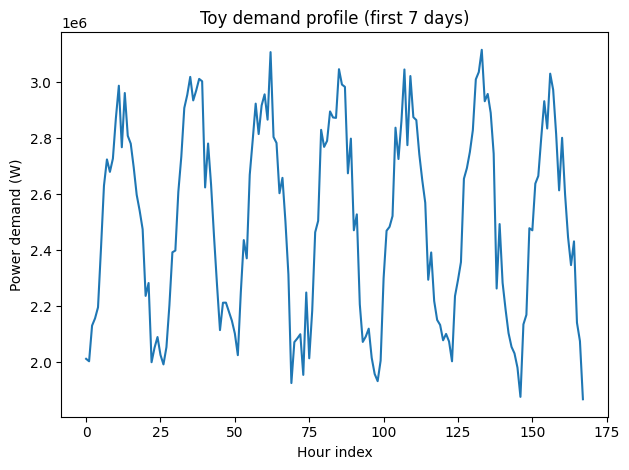

In [18]:
rng = np.random.default_rng(0)

baseline_W = np.nan  # TODO: choose & justify baseline demand (W)
daily_amp_W = np.nan  # TODO: choose & justify daily swing amplitude (W)

if np.isnan(baseline_W) or np.isnan(daily_amp_W):
    raise ValueError("Set baseline_W and daily_amp_W (and justify) before running the demand model.")

# Build a daily sinusoid with period 24 hours
demand = baseline_W + daily_amp_W * (0.5 + 0.5*np.sin(2*np.pi*(t_hours/24.0 - 0.25)))
demand = demand + rng.normal(0, 1e5, size=len(demand))  # noise
demand = np.clip(demand, 0, None)

plt.figure()
plt.plot(t_hours[:24*7], demand[:24*7])
plt.title("Toy demand profile (first 7 days)")
plt.xlabel("Hour index")
plt.ylabel("Power demand (W)")
plt.tight_layout()
plt.show()

### Answer (Phase 2.2)

*Describe what your toy demand represents and what its limitations are. If you change parameters (baseline, amplitude), justify briefly.*

## Storage dispatch model used below

We have:
- **Supply** $P_{\text{supply}}(t)$ (W): produced by your technology (from the earlier conversion cell).
- **Demand** $P_{\text{demand}}(t)$ (W): the load the community/system needs at time $t$.
- **Stored energy** $S(t)$ (J): how much energy is currently stored.

At each time step (1 hour), we follow this simple logic:

1. If supply exceeds demand, use supply to meet demand and put the surplus into storage (charging), up to:
   - the storage capacity $S_{\max}$ and
   - the charge-rate limit $P_{\text{charge,max}}$.
2. If supply is less than demand, discharge storage to try to cover the deficit, up to:
   - the available stored energy $S(t)$ and
   - the discharge-rate limit $P_{\text{discharge,max}}$.

This produces a time series $S(t)$ and a binary indicator: **did we meet demand at that hour?**

### Why choose $S_{\max}$?

Choosing $S_{\max}$ is a modelling decision: it encodes how much storage infrastructure you are assuming.
A useful interpretation is “how many hours of baseline demand can the storage cover?”

Example: if baseline demand is 2 MW, then 4 hours of coverage corresponds to:
$$
S_{\max} = (2\times 10^6\ \text{W})\cdot (4\ \text{h}) = 8\times 10^6\ \text{Wh} = 8\ \text{MWh}.
$$
In Joules, that is $8\ \text{MWh}\times 3.6\times 10^9\ \text{J/MWh}$.

### Your task (answer block below)
- Explain your chosen values of $S_{\max}$, $P_{\text{charge,max}}$, and $P_{\text{discharge,max}}$.
- Give a short “engineering meaning” (e.g., hours of coverage, plausible charge/discharge rate).


In [ ]:
S_max_J = np.nan  # TODO: choose & justify storage capacity (J)
P_charge_max = np.nan  # TODO: choose & justify max charging power (W)
P_discharge_max = np.nan  # TODO: choose & justify max discharging power (W)

if np.isnan(S_max_J) or np.isnan(P_charge_max) or np.isnan(P_discharge_max):
    raise ValueError("Set S_max_J, P_charge_max, P_discharge_max (and justify) before running the storage simulation.")

dt = 3600.0  # seconds per step (hourly)

S = np.zeros(len(t_hours))
met = np.zeros(len(t_hours), dtype=bool)

for k in range(1, len(t_hours)):
    # available surplus/deficit before storage
    surplus = Pin[k-1] - demand[k-1]
    if surplus >= 0:
        # charge storage
        charge = min(surplus, P_charge_max)
        S[k] = min(S_max_J, S[k-1] + charge*dt)
        supplied = demand[k-1]
        met[k-1] = True
    else:
        # discharge if possible
        need = -surplus
        discharge = min(need, P_discharge_max, S[k-1]/dt)
        supplied = Pin[k-1] + discharge
        S[k] = max(0.0, S[k-1] - discharge*dt)
        met[k-1] = supplied >= demand[k-1] - 1e-6

# summarize
fraction_met = met.mean()
print(f"Fraction of hours demand met: {fraction_met:.3f}")

plt.figure()
plt.plot(t_hours[:24*7], S[:24*7]/3.6e9)  # J to MWh (1 MWh = 3.6e9 J)
plt.title("Storage state of charge (first 7 days)")
plt.xlabel("Hour index")
plt.ylabel("Stored energy (MWh)")
plt.tight_layout()
plt.show()

## Numerically solving the ODE with `solve_ivp` (required)

The loop above is a **discrete-time simulation** (hour-by-hour bookkeeping).  
In this section you will also solve a **continuous-time ODE** using SciPy.

### ODE we solve

We model stored energy $S(t)$ (J) with:

$$
\frac{dS}{dt} = u(t),
$$

where $u(t)$ is the **net charging power** (W) after applying rate limits and storage bounds.

Let $P_{\text{supply}}(t)$ be supply and $P_{\text{demand}}(t)$ be demand. Define the unconstrained net power:
$$
u_0(t) = P_{\text{supply}}(t) - P_{\text{demand}}(t).
$$

We then apply the **power limits**:
- charging cannot exceed $P_{\text{charge,max}}$
- discharging cannot exceed $P_{\text{discharge,max}}$

and also prevent $S(t)$ from leaving $[0,S_{\max}]$ by setting $u(t)=0$ when the storage is full and would charge, or empty and would discharge.

### Your task
- Run the ODE solver and compare its $S(t)$ curve to the discrete simulation.
- Briefly explain why the curves may not match exactly (hint: discretization, piecewise definitions, interpolation).


In [ ]:
# ODE solve using solve_ivp (continuous time)

from scipy.interpolate import interp1d

# Hourly samples indexed by t_hours (0,1,2,...) and arrays Pin (supply) and demand.
# Convert to seconds for the ODE solver.
t_sec = t_hours * 3600.0

# Use "previous" interpolation so the solver sees piecewise-constant inputs within each hour.
Pin_fun = interp1d(t_sec, Pin, kind="previous", fill_value="extrapolate")
demand_fun = interp1d(t_sec, demand, kind="previous", fill_value="extrapolate")

def dSdt(t, S):
    """dS/dt in J/s. We apply ONLY power-rate limits here.

    Note: enforcing hard bounds (0 <= S <= S_max) directly inside the RHS can create
    discontinuities that make adaptive ODE solvers struggle. We instead:
      1) solve the rate-limited ODE, then
      2) clip S(t) to [0, S_max] for interpretation/plots.
    """
    u0 = float(Pin_fun(t) - demand_fun(t))  # net power (W) = J/s
    # Apply charge/discharge power limits
    u = min(u0, float(P_charge_max))
    u = max(u, -float(P_discharge_max))
    return [u]

# Initial condition (start empty)
S0 = [0.0]

sol = solve_ivp(
    dSdt,
    t_span=(t_sec[0], t_sec[-1]),
    y0=S0,
    t_eval=t_sec,
    method="RK23",
    rtol=1e-4,
    atol=1.0,
    max_step=3600.0,
)

S_ode_raw = sol.y[0] if sol.y is not None else None

# If the solver fails (rare but possible), fall back to a direct numerical integral.
if (not sol.success) or (S_ode_raw is None) or (len(S_ode_raw) != len(t_sec)):
    print("solve_ivp did not succeed; falling back to trapezoid integration.")
    print("Message:", sol.message)
    u_hourly = np.clip(Pin - demand, -float(P_discharge_max), float(P_charge_max))
    S_ode_raw = np.concatenate([[0.0], np.cumsum(u_hourly[:-1] * 3600.0)])

# Clip to physical bounds for interpretation
S_ode = np.clip(S_ode_raw, 0.0, float(S_max_J))

plt.figure()
plt.plot(t_hours[:24*7], (S[:24*7] / 3.6e9), label="Discrete bookkeeping")
plt.plot(t_hours[:24*7], (S_ode[:24*7] / 3.6e9), label="ODE solve (rate-limited, clipped)")
plt.title("Storage state of charge (first 7 days): discrete vs ODE solve")
plt.xlabel("Hour index")
plt.ylabel("Stored energy (MWh)")
plt.legend()
plt.tight_layout()
plt.show()

print("solve_ivp success:", sol.success)
print("solve_ivp message:", sol.message)


### Answer (Phase 2.4)

*Compare the discrete and ODE curves. Why do they differ? Which do you trust more for which purpose?*

### Answer (Phase 2.3)

*Interpret your results. When does the system fail to meet demand? How does changing $S_{\max}$ or the charge/discharge limits affect reliability?*

## Final checklist (before submission)

- [ ] Notebook runs top-to-bottom with no errors.  
- [ ] All **embedded checks** pass.  
- [ ] You wrote short markdown justifications for chosen parameters (efficiency, area, head, storage size, etc.).  
- [ ] You created at least **one plot** that supports interpretation in Phase 1 and **one plot** in Phase 2.  
- [ ] Your group repository is **public** and shared among members; includes `README.md`.  
- [ ] You are ready to cite your repo (link) in the final write-up if you use this work.

